<a href="https://colab.research.google.com/github/imadeardanabapeten/Analisis-Sentimen-Aplikasi-Access-by-KAI/blob/main/Analisis_Sentimen_Access_by_KAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Import Library***

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix


# ***Load Data Hasil Scraping***

In [7]:
df = pd.read_csv("hasil_scraper_ulasan_APP_1.csv")
df.head(10)

,reviewId,userName,rating,review_txt,date
0,d4e4902d-5b78-46b3-adf3-ff69e8f76430,Pengguna Google,5,bagus banget,2026-02-04 13:16:13
1,5b2dc292-306f-4a3c-86a7-3e89f1a8bc92,Pengguna Google,5,mantap,2026-02-04 12:49:36
2,5737aa63-e8f9-47d1-9c7b-363c0aba881b,Pengguna Google,5,luar biasa...mantap... terimakasih pelayanan nya,2026-02-04 12:13:15
3,91bef259-f403-4483-996c-8231a42e6ba8,Pengguna Google,1,makin di-update makin banyak masalah nya,2026-02-04 11:24:02
4,cd27b68a-fdac-474f-8b62-de861f3af48c,Pengguna Google,5,"sebenarnya aplikasi ini memudahkan,tp knp bebe...",2026-02-04 09:45:24
5,3133fcd5-7ebb-4abe-9032-35faaeecb443,Pengguna Google,5,sngt membatu,2026-02-04 08:41:29
6,823e3abc-343d-4ea6-a41c-24307dddeb2c,Pengguna Google,5,kenapa war tiket lebaran tahun ini susah bange...,2026-02-04 08:33:13
7,6c267913-399d-4637-b314-09ca266fa632,Pengguna Google,5,cepat,2026-02-04 08:02:44
8,fed9b129-2536-47ec-b349-bccb597bdf72,Pengguna Google,5,mantap,2026-02-04 07:30:16
9,5ad20112-84c0-4fc3-a11b-5130882ea6f1,Pengguna Google,5,good,2026-02-04 05:51:30


# ***Analisis Distribusi Ratng Pengguna***

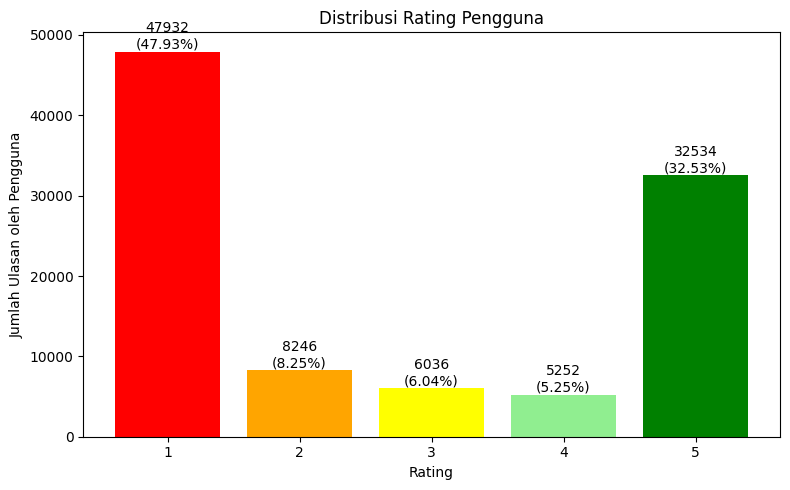

In [20]:
df = pd.read_csv("hasil_scraper_ulasan_APP_1.csv")

# Pastikan rating numerik
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Hitung distribusi rating 1–5
distribusi = (
    df['rating']
    .value_counts()
    .reindex([1, 2, 3, 4, 5], fill_value=0)
    .sort_index()
)

total = distribusi.sum()
persentase = (distribusi / total) * 100

# Warna berbeda untuk tiap rating
colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']

# Membuat grafik
plt.figure(figsize=(8, 5))
bars = plt.bar(distribusi.index, distribusi.values, color=colors)

plt.xlabel("Rating")
plt.ylabel("Jumlah Ulasan oleh Pengguna")
plt.title("Distribusi Rating Pengguna")
plt.xticks([1, 2, 3, 4, 5])

# Menambahkan jumlah & persentase di atas batang
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}\n({persentase.iloc[i]:.2f}%)",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

# ***Normalization menggunakan Kamus Sastrawi***

In [10]:
!wget -O kamus_alay.csv https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv
!pip install Sastrawi

--2026-02-08 01:45:31--  https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3093160 (2.9M) [text/plain]
Saving to: ‘kamus_alay.csv’

kamus_alay.csv      100%[===================>]   2.95M  --.-KB/s    in 0.02s   

2026-02-08 01:45:31 (154 MB/s) - ‘kamus_alay.csv’ saved [3093160/3093160]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 12.0 MB/s eta 0:00:00


In [11]:

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
# 1. Load the dictionary from CSV
# The CSV usually has columns like: [slang, formal, category...]
kamus_df = pd.read_csv("kamus_alay.csv")

# 2. Convert to a Python Dictionary { 'slang': 'formal' }
# We assume the first column is slang and the second is formal
# This creates a map like: {'ak': 'aku', 'yg': 'yang', ...}
norm_dict = dict(zip(kamus_df['slang'], kamus_df['formal']))

# 3. Setup Stopword Remover (Sastrawi)
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

def preprocess_text_complete(t):
    # 1. CLEANING
    t = str(t).lower()
    t = re.sub(r"http\S+", "", t)
    t = re.sub(r"[^a-zA-Z0-9\s]", " ", t)

    # 2. NORMALIZATION (Slang -> Formal)
    words = t.split()
    normalized_words = [norm_dict.get(word, word) for word in words]

    # Join back to string for Sastrawi (it expects a sentence, not a list)
    t = " ".join(normalized_words)

    # 3. STOPWORD REMOVAL (Removing 'yang', 'dan', 'di'...)
    t = stopword_remover.remove(t)

    return t

# --- C. APPLY IT ---
print("🚀 Preprocessing data (Cleaning + Norm + Stopwords)...")
df["clean"] = df["review_txt"].apply(preprocess_text_complete)

# Show the 'Before' vs 'After' to prove it works
print("Done!")
df[["review_txt", "clean"]].head(20)

🚀 Preprocessing data (Cleaning + Norm + Stopwords)...
Done!


,review_txt,clean
0,bagus banget,bagus banget
1,mantap,mantap
2,luar biasa...mantap... terimakasih pelayanan nya,luar biasa mantap terimakasih pelayanan nya
3,makin di-update makin banyak masalah nya,makin update makin banyak masalah nya
4,"sebenarnya aplikasi ini memudahkan,tp knp bebe...",sebenarnya aplikasi memudahkan kenapa beberapa...
5,sngt membatu,sangat membatu
6,kenapa war tiket lebaran tahun ini susah bange...,war tiket lebaran tahun susah banget min 4hari...
7,cepat,cepat
8,mantap,mantap
9,good,good


# ***Tokenisasi***

In [12]:
import nltk
from nltk.tokenize import word_tokenize

# 1. Download the NLTK tokenizer data (run this once)
nltk.download('punkt')
nltk.download('punkt_tab') # Sometimes required for newer versions

# 2. Define the Tokenizer Function
def tokenize_text(text):
    # This splits "aplikasi ini bagus" into ['aplikasi', 'ini', 'bagus']
    return word_tokenize(text)

# 3. Apply it
print("✂️ Tokenizing text...")
df["tokens"] = df["clean"].apply(tokenize_text)

# Show the result
print("Done!")
df[["clean", "tokens"]].head(20)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✂️ Tokenizing text...
Done!


,clean,tokens
0,bagus banget,"[bagus, banget]"
1,mantap,[mantap]
2,luar biasa mantap terimakasih pelayanan nya,"[luar, biasa, mantap, terimakasih, pelayanan, ..."
3,makin update makin banyak masalah nya,"[makin, update, makin, banyak, masalah, nya]"
4,sebenarnya aplikasi memudahkan kenapa beberapa...,"[sebenarnya, aplikasi, memudahkan, kenapa, beb..."
5,sangat membatu,"[sangat, membatu]"
6,war tiket lebaran tahun susah banget min 4hari...,"[war, tiket, lebaran, tahun, susah, banget, mi..."
7,cepat,[cepat]
8,mantap,[mantap]
9,good,[good]


# ***Stemming***

In [13]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# 1. Create the Stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# 2. Define the Stemming Function
# Sastrawi's stem() function takes a STRING (Sentence), not a LIST.
# It automatically handles the tokenization internally.
def stem_text(text):
    return stemmer.stem(text)

# 3. Apply it
# We apply this to the 'clean' column (the String), not the 'tokens' column.
print("🌱 Stemming text... (Go grab a coffee, this is slow)")
df["stemmed"] = df["clean"].apply(stem_text)

# Show the result
print("Done!")
df[["clean", "stemmed"]].head(20)

🌱 Stemming text... (Go grab a coffee, this is slow)
Done!


,clean,stemmed
0,bagus banget,bagus banget
1,mantap,mantap
2,luar biasa mantap terimakasih pelayanan nya,luar biasa mantap terimakasih layan nya
3,makin update makin banyak masalah nya,makin update makin banyak masalah nya
4,sebenarnya aplikasi memudahkan kenapa beberapa...,benar aplikasi mudah kenapa beberapa hari susa...
5,sangat membatu,sangat batu
6,war tiket lebaran tahun susah banget min 4hari...,war tiket lebaran tahun susah banget min 4hari...
7,cepat,cepat
8,mantap,mantap
9,good,good


# ***Labeling dari rating***

In [21]:
def label_sentiment(r):
    if r >= 4:
        return "positive"
    elif r == 3:
        return "neutral"
    else:
        return "negative"

df["label"] = df["rating"].apply(label_sentiment)
df.head(20)

,reviewId,userName,rating,review_txt,date,label
0,d4e4902d-5b78-46b3-adf3-ff69e8f76430,Pengguna Google,5,bagus banget,2026-02-04 13:16:13,positive
1,5b2dc292-306f-4a3c-86a7-3e89f1a8bc92,Pengguna Google,5,mantap,2026-02-04 12:49:36,positive
2,5737aa63-e8f9-47d1-9c7b-363c0aba881b,Pengguna Google,5,luar biasa...mantap... terimakasih pelayanan nya,2026-02-04 12:13:15,positive
3,91bef259-f403-4483-996c-8231a42e6ba8,Pengguna Google,1,makin di-update makin banyak masalah nya,2026-02-04 11:24:02,negative
4,cd27b68a-fdac-474f-8b62-de861f3af48c,Pengguna Google,5,"sebenarnya aplikasi ini memudahkan,tp knp bebe...",2026-02-04 09:45:24,positive
5,3133fcd5-7ebb-4abe-9032-35faaeecb443,Pengguna Google,5,sngt membatu,2026-02-04 08:41:29,positive
6,823e3abc-343d-4ea6-a41c-24307dddeb2c,Pengguna Google,5,kenapa war tiket lebaran tahun ini susah bange...,2026-02-04 08:33:13,positive
7,6c267913-399d-4637-b314-09ca266fa632,Pengguna Google,5,cepat,2026-02-04 08:02:44,positive
8,fed9b129-2536-47ec-b349-bccb597bdf72,Pengguna Google,5,mantap,2026-02-04 07:30:16,positive
9,5ad20112-84c0-4fc3-a11b-5130882ea6f1,Pengguna Google,5,good,2026-02-04 05:51:30,positive


# ***Download table after stemmed and labeling***

In [22]:
from google.colab import files

df.to_csv('sentiment_data.csv', index=False)
files.download('sentiment_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ***WordCloud***

In [43]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [52]:
def show_wordcloud_top_n(text_series, title, top_n=50):
    # Gabungkan teks
    text = " ".join(text_series.dropna().astype(str)).lower()

    # Cleaning ringan
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text)

    # Tokenisasi
    words = text.split()

    # Hapus stopwords
    words = [w for w in words if w not in stopwords_id and len(w) > 2]

    if len(words) == 0:
        print(f"Tidak ada kata untuk {title}")
        return

    # Ambil TOP-N kata paling sering
    word_freq = Counter(words)
    most_common_words = dict(word_freq.most_common(top_n))

    # Buat WordCloud
    wc = WordCloud(
        width=1000,
        height=500,
        background_color="white",
        collocations=False
    ).generate_from_frequencies(most_common_words)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title)
    plt.show()

    show_wordcloud_top_n(
    df[df["label"] == "positive"]["review_txt"],
    "Word Cloud Top 50 Kata – Sentimen Positif (Access by KAI)",
    top_n=50
)

# ***Split Data***

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df["stemmed"], df["label"], test_size=0.2, random_state=42
)

# ***TF-IDF Vectorizer***

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    sublinear_tf=True,
    min_df=3
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


# ***Train SVM***

In [ ]:
svm = LinearSVC(class_weight='balanced', random_state=42)
svm.fit(X_train_vec, y_train)

LinearSVC(class_weight='balanced', random_state=42)

# ***Evaluation the model***

In [ ]:
y_pred = svm.predict(X_test_vec)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.87      0.86      0.86     11149
     neutral       0.18      0.23      0.20      1262
    positive       0.89      0.85      0.87      7589

    accuracy                           0.82     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.83      0.82      0.83     20000

[[9618  967  564]
 [ 758  291  213]
 [ 723  389 6477]]


In [ ]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm

              precision    recall  f1-score   support

    negative       0.87      0.86      0.86     11149
     neutral       0.18      0.23      0.20      1262
    positive       0.89      0.85      0.87      7589

    accuracy                           0.82     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.83      0.82      0.83     20000



array([[9618,  967,  564],
       [ 758,  291,  213],
       [ 723,  389, 6477]])

# ***Graph***

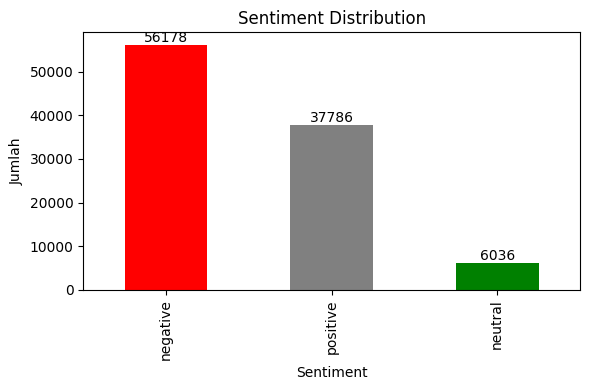

In [ ]:

plt.figure(figsize=(6,4))

# Capture the axes object 'ax' to manipulate the plot elements
ax = df['label'].value_counts().plot(kind='bar', color=['red','gray','green'])

# Add the specific values to the bars
ax.bar_label(ax.containers[0])

plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

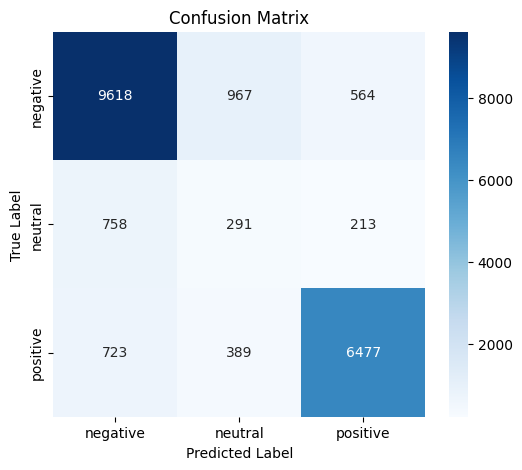

In [ ]:
labels = ['negative', 'neutral', 'positive']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
